In [1]:
"""
r: Zongyi Li and Daniel Zhengyu Huang
"""

import numpy
import torch.nn.functional as F
import matplotlib.pyplot as plt
from timeit import default_timer
from catheter import *
from utilities3 import *
from Adam import Adam

torch.manual_seed(0)
np.random.seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print("device is ", (device))

device is  cuda


In [2]:
def Lx2length(L_x, L_p, x1, x2, x3, h):
    l0, l1, l2, l3 = -x3, torch.sqrt((x2-x3)**2 + h**2), torch.sqrt((x1-x2)**2 + h**2), L_p+x1
    if L_x < -x3:
        l = L_x
    elif L_x < -x2:
        l = l0 + l1*(L_x + x3)/(x3-x2)
    elif L_x < -x1:
        l = l0 + l1 + l2*(L_x + x2)/(x2-x1)
    else:
        l = l0 + l1 + l2 + L_x+x1

    return l

def d2xy(d, L_p, x1, x2, x3, h):
    
    p0, p1, p2, p3 = torch.tensor([0.0,0.0]), torch.tensor([x3,0.0]), torch.tensor([x2, h]), torch.tensor([x1,0.0])
    v0, v1, v2, v3 = torch.tensor([x3-0,0.0]), torch.tensor([x2-x3,h]), torch.tensor([x1-x2,-h]), torch.tensor([-L_p-x1,0.0])
    l0, l1, l2, l3 = -x3, torch.sqrt((x2-x3)**2 + h**2), torch.sqrt((x1-x2)**2 + h**2), L_p+x1
    
    xx, yy = torch.zeros(d.shape), torch.zeros(d.shape)
    ind = (d < l0)
    xx[ind] = d[ind]*v0[0]/l0 + p0[0]
    yy[ind] = d[ind]*v0[1]/l0 + p0[1]
    
    ind = torch.logical_and(d < l0 + l1, d>=l0)
    xx[ind] = (d[ind]-l0)*v1[0]/l1 + p1[0] 
    yy[ind] = (d[ind]-l0)*v1[1]/l1 + p1[1]
    
    ind = torch.logical_and(d < l0 + l1 + l2, d>=l0 + l1)
    xx[ind] = (d[ind]-l0-l1)*v2[0]/l2 + p2[0]
    yy[ind] = (d[ind]-l0-l1)*v2[1]/l2 + p2[1]
    
    ind = (d>=l0 + l1 + l2)
    xx[ind] = (d[ind]-l0-l1-l2)*v3[0]/l3 + p3[0]
    yy[ind] = (d[ind]-l0-l1-l2)*v3[1]/l3 + p3[1]
    

    return xx, yy

def catheter_mesh_1d_total_length(L_x, L_p, x2, x3, h, N_s):
    x1 = -0.5*L_p
    # ncy = 20
    
    n_periods = torch.floor(L_x / L_p)
    L_x_last_period = L_x - n_periods*L_p
    L_p_s = ((x1 + L_p) + (0 - x3) + torch.sqrt((x2 - x1)**2 + h**2) + torch.sqrt((x3 - x2)**2 + h**2))
    L_s = L_p_s*n_periods + Lx2length(L_x_last_period, L_p, x1, x2, x3, h)
    
    # from 0
    d_arr = torch.linspace(0, 1, N_s) * L_s
    
    # TODO do not compute gradient for floor
    period_arr = torch.floor(d_arr / L_p_s).detach()
    d_arr -= period_arr * L_p_s

    
    xx, yy = d2xy(d_arr, L_p, x1, x2, x3, h)
        
    xx = xx - period_arr*L_p
    
    
    X_Y = torch.zeros((1, N_s, 2), dtype=torch.float).to(device)
    X_Y[0, :, 0], X_Y[0, :, 1] = xx, yy
    return X_Y, xx, yy




1d X error =  0.0005472336590786565
1d Y error =  0.00038736877123649244


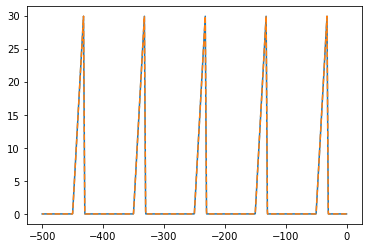

In [3]:
L_x, L_p, x2, x3, h = 500, 100, -32, -30, 30
x1 = -0.5*L_p
N_s = 1001
X0,Y0 = numpy_catheter_mesh_1d_total_length(L_x, L_p, x1, x2, x3, h, N_s)

L_p, x2, x3, h =  torch.tensor(L_p, dtype=torch.float), torch.tensor(x2, dtype=torch.float), torch.tensor(x3, dtype=torch.float), torch.tensor(h, dtype=torch.float)
X_Y, X, Y = catheter_mesh_1d_total_length(L_x, L_p, x2, x3, h, N_s)



print("1d X error = ", np.linalg.norm(X0 - X.cpu().numpy()))
print("1d Y error = ", np.linalg.norm(Y0 - Y.cpu().numpy()))
X_Y_numpy = X_Y.cpu().numpy()
plt.plot(X0, Y0)
plt.plot(X_Y_numpy[0, :, 0], X_Y_numpy[0, :, 1], "--")

# ##################################################
# # Prediction on a special design
# #################################################
# model = torch.load("catheter_plain_period_model_1d500", map_location=device)
# out = torch.clip(model(X_Y).squeeze(), min=0.0).detach().cpu().numpy()
# xx_mask = numpy.linspace(1.0, 0, n_periods*ncx+1) * (-L_p*n_periods)
# print("L_p, x1, x2, x3, h  = ", L_p, x1, x2, x3, h)
# print("loss = ",  -np.dot(out,xx_mask) )
# plt.figure()
# plt.plot(xx_mask, out)


[785.           5.03008     62.87507539 -31.43753769  -8.69985683
 -15.85508335  28.01017283]
sample =  785.0
min loss =  262913.0332581358 L_p, x2, x3, h =  tensor(62.8751) tensor(-8.6999) tensor(-15.8551) tensor(28.0102)
predicted loss:  259633.61964789432
3279.4136102415446
0.24987506246876562


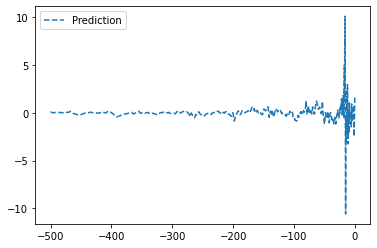

In [4]:
# All data design results
PATH = "/groups/esm/dzhuang/Catheter/allparam/length/"
INPUT_X = PATH+"x_1d_structured_mesh.npy"
INPUT_Y = PATH+"y_1d_structured_mesh.npy"
INPUT_para = PATH+"data_info.npy"
OUTPUT = PATH+"density_1d_data.npy"
n_data = 3000
inputX_raw = np.load(INPUT_X)[:, 0:n_data]
inputY_raw = np.load(INPUT_Y)[:, 0:n_data]
inputPara_raw = np.load(INPUT_para)[:, 0:n_data]
output_raw = np.load(OUTPUT)[:, 0:n_data]


# nx ny
L_x , N_s = 500.0, 2001

################################################################
# load data and data normalization
################################################################
inputX = inputX_raw[:, 0::3]
inputY = inputY_raw[:, 0::3]
inputPara = inputPara_raw[:, 0::3]
output = (output_raw[:, 0::3] + output_raw[:, 1::3] + output_raw[:, 2::3])/ 3.0


n_data = inputX.shape[1]
all_loss = np.zeros(n_data)


for i in range(n_data):
    
    sample, uf, L_p, x1, x2, x3, h = inputPara[:, i]
    xx_mask = numpy.linspace(1.0, 0, N_s) * (-L_x)
    all_loss[i] = -np.dot(output[:, i], xx_mask) * L_x/N_s

    

loss_min_ind = np.argmin(all_loss)
loss_min = all_loss[loss_min_ind]
sample, uf, L_p, x1, x2, x3, h = inputPara[:, loss_min_ind]

model = torch.load("catheter_plain_length_model_1d500", map_location=device)
L_p, x2, x3, h =  torch.tensor(L_p, dtype=torch.float), torch.tensor(x2, dtype=torch.float), torch.tensor(x3, dtype=torch.float), torch.tensor(h, dtype=torch.float)

X_Y, X, Y = catheter_mesh_1d_total_length(L_x, L_p, x2, x3, h, N_s)
out = torch.exp(model(X_Y).squeeze()).detach().cpu().numpy()


print(inputPara[:, loss_min_ind])
print("sample = ", sample)
print("min loss = ", loss_min, "L_p, x2, x3, h = ", L_p, x2, x3, h)

xx_mask = numpy.linspace(1.0, 0, N_s) * (-L_x)
print("predicted loss: ", -np.dot(out, xx_mask) * L_x/N_s)

density = output[:, loss_min_ind]
mesh_X = inputX[:, loss_min_ind]
mesh_Y = inputY[:, loss_min_ind]
plt.figure()
# plt.plot(xx_mask, density, label="Reference")
plt.plot(xx_mask, out - density, "--", label="Prediction")
# plt.plot(mesh_X, mesh_Y)
plt.legend()

print(np.dot(out - density, xx_mask) * L_x/N_s)
print(L_x/N_s)

# BFGS

1336001
initialize :  [ 1.32175584 -0.84729786  1.79175947  0.        ]
initialize :  (tensor(100., grad_fn=<AddBackward0>), tensor(-50., grad_fn=<MulBackward0>), tensor(-30., grad_fn=<AddBackward0>), tensor(-30., grad_fn=<AddBackward0>), tensor(25., grad_fn=<AddBackward0>))
0 0.5089502818882465 loss =  405698.75 loss_min =  inf
tensor([ 2.1495, -1.1508,  1.6836, -0.1097], grad_fn=<CloneBackward0>)
L_p, x1, x2, x3, h  =  79.83110046386719 -39.915550231933594 -19.18646240234375 -21.013412475585938 25.273906707763672


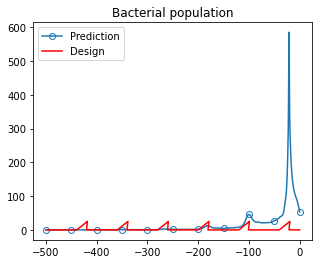

1 0.152676023542881 loss =  510027.65625 loss_min =  405698.75
2 0.150367496535182 loss =  785058.6875 loss_min =  405698.75
3 0.16337077133357525 loss =  517611.75 loss_min =  405698.75
4 0.16467968001961708 loss =  974724.75 loss_min =  405698.75
5 0.16392670199275017 loss =  411908.21875 loss_min =  405698.75
6 0.16371088102459908 loss =  854595.3125 loss_min =  405698.75
7 0.16500754095613956 loss =  652734.0 loss_min =  405698.75
8 0.1498198863118887 loss =  363909.15625 loss_min =  405698.75
tensor([ 2.1287, -1.8693,  2.2023, -1.4222], grad_fn=<CloneBackward0>)
L_p, x1, x2, x3, h  =  80.20501708984375 -40.102508544921875 -10.717155456542969 -22.603641510009766 28.056821823120117


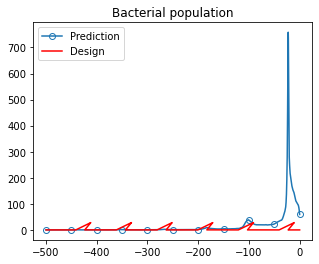

9 0.14193986169993877 loss =  316439.5625 loss_min =  363909.15625
tensor([ 2.3207, -1.3265, -0.0165, -1.1632], grad_fn=<CloneBackward0>)
L_p, x1, x2, x3, h  =  76.99105834960938 -38.49552917480469 -16.14757537841797 -11.650812149047852 27.61915397644043


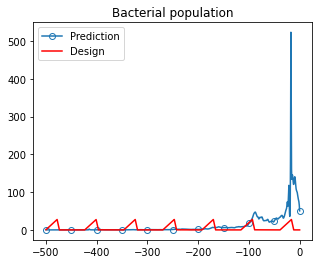

10 0.15009408071637154 loss =  388738.28125 loss_min =  316439.5625
11 0.15023218467831612 loss =  299158.0625 loss_min =  316439.5625
tensor([ 2.2802, -1.0384, -0.0240, -2.0777], grad_fn=<CloneBackward0>)
L_p, x1, x2, x3, h  =  77.62690734863281 -38.813453674316406 -20.29596710205078 -11.763595581054688 28.88717269897461


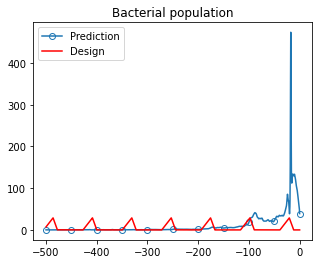

12 0.16033747792243958 loss =  363734.90625 loss_min =  299158.0625
13 0.1600396502763033 loss =  292018.625 loss_min =  299158.0625
tensor([ 4.3378, -1.0738,  0.0387, -2.8440], grad_fn=<CloneBackward0>)
L_p, x1, x2, x3, h  =  62.4503173828125 -31.22515869140625 -15.904441833496094 -8.269439697265625 29.450082778930664


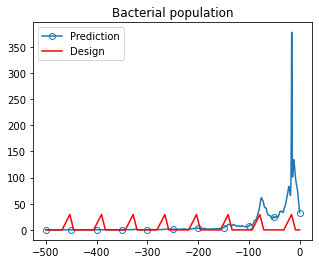

14 0.16160751320421696 loss =  720135.6875 loss_min =  292018.625
15 0.1470381934195757 loss =  279020.25 loss_min =  292018.625
tensor([ 2.8323, -1.7348,  1.3619, -2.8069], grad_fn=<CloneBackward0>)
L_p, x1, x2, x3, h  =  70.5643081665039 -35.28215408325195 -10.582656860351562 -16.145904541015625 29.43047332763672


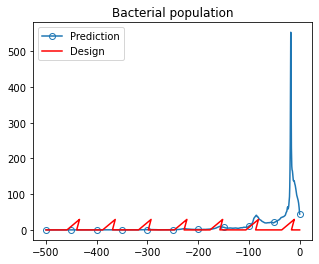

16 0.15384019911289215 loss =  404254.28125 loss_min =  279020.25
17 0.1492666769772768 loss =  329140.53125 loss_min =  279020.25
18 0.1506316363811493 loss =  267061.40625 loss_min =  279020.25
tensor([ 4.2270, -0.5637,  1.7954, -4.5411], grad_fn=<CloneBackward0>)
L_p, x1, x2, x3, h  =  62.73345184326172 -31.36672592163086 -22.752613067626953 -14.035886764526367 29.894512176513672


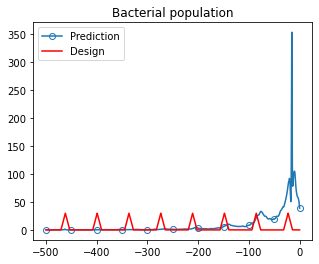

19 0.1591898910701275 loss =  521894.15625 loss_min =  267061.40625
20 0.15892320312559605 loss =  376956.59375 loss_min =  267061.40625
21 0.16205056570470333 loss =  485781.34375 loss_min =  267061.40625
22 0.1615967694669962 loss =  450106.09375 loss_min =  267061.40625
23 0.16257326491177082 loss =  330431.15625 loss_min =  267061.40625
24 0.1477334275841713 loss =  254544.890625 loss_min =  267061.40625
tensor([ 4.4729, -0.6949,  1.6169, -5.1370], grad_fn=<CloneBackward0>)
L_p, x1, x2, x3, h  =  62.144195556640625 -31.072097778320312 -20.69070053100586 -13.409966468811035 29.941593170166016


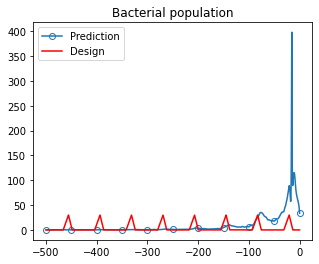

25 0.16222296841442585 loss =  357577.9375 loss_min =  254544.890625
26 0.16093708761036396 loss =  682495.125 loss_min =  254544.890625
27 0.17374658212065697 loss =  652845.0 loss_min =  254544.890625
28 0.1385463885962963 loss =  246213.125 loss_min =  254544.890625
tensor([ 4.9717, -1.2182,  1.3654, -6.1926], grad_fn=<CloneBackward0>)
L_p, x1, x2, x3, h  =  61.30789566040039 -30.653947830200195 -13.993610382080078 -12.470476150512695 29.979595184326172


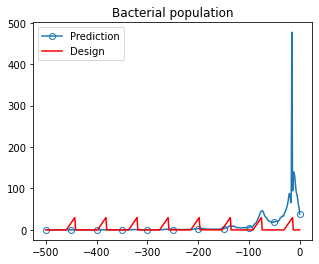

29 0.14209301583468914 loss =  233384.8125 loss_min =  246213.125
tensor([ 4.4124, -1.3379,  1.2018, -6.4430], grad_fn=<CloneBackward0>)
L_p, x1, x2, x3, h  =  62.27626419067383 -31.138132095336914 -12.944263458251953 -12.407851219177246 29.98410987854004


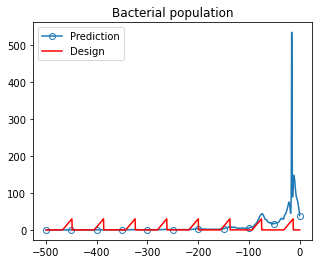

30 0.15153411962091923 loss =  269760.8125 loss_min =  233384.8125
31 0.16168060898780823 loss =  404959.0 loss_min =  233384.8125
32 0.15379657596349716 loss =  277630.5625 loss_min =  233384.8125
33 0.1480492800474167 loss =  252228.90625 loss_min =  233384.8125
34 0.14242225140333176 loss =  290265.125 loss_min =  233384.8125
35 0.1591296438127756 loss =  479697.0625 loss_min =  233384.8125
36 0.1548118256032467 loss =  366046.71875 loss_min =  233384.8125
37 0.14934715628623962 loss =  266872.5625 loss_min =  233384.8125
38 0.09732450358569622 loss =  235015.21875 loss_min =  233384.8125
39 0.09551865234971046 loss =  315616.625 loss_min =  233384.8125
40 0.1431786958128214 loss =  277617.0625 loss_min =  233384.8125
41 0.1519579403102398 loss =  506846.6875 loss_min =  233384.8125
42 0.09828471392393112 loss =  248429.578125 loss_min =  233384.8125
43 0.0979471430182457 loss =  261872.015625 loss_min =  233384.8125
44 0.145557077601552 loss =  312583.3125 loss_min =  233384.8125
4

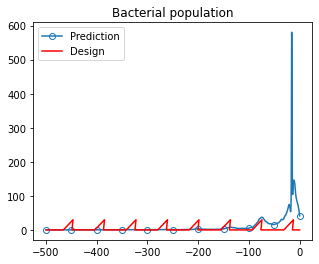

66 0.15033393912017345 loss =  296585.65625 loss_min =  224820.25
67 0.15411175601184368 loss =  312761.3125 loss_min =  224820.25
68 0.09120979532599449 loss =  281227.84375 loss_min =  224820.25
69 0.15487434156239033 loss =  271485.25 loss_min =  224820.25
70 0.08013066090643406 loss =  318765.3125 loss_min =  224820.25
71 0.14134611375629902 loss =  264507.46875 loss_min =  224820.25
72 0.10108818300068378 loss =  252316.296875 loss_min =  224820.25
73 0.1419704705476761 loss =  281473.09375 loss_min =  224820.25
74 0.15373294241726398 loss =  271114.25 loss_min =  224820.25
75 0.15282299369573593 loss =  374183.46875 loss_min =  224820.25
76 0.1542416848242283 loss =  245157.28125 loss_min =  224820.25
77 0.09806883707642555 loss =  267364.59375 loss_min =  224820.25
78 0.08765562437474728 loss =  232209.609375 loss_min =  224820.25
79 0.10043532960116863 loss =  316412.5 loss_min =  224820.25
80 0.08643898367881775 loss =  390314.34375 loss_min =  224820.25
81 0.14317156001925468

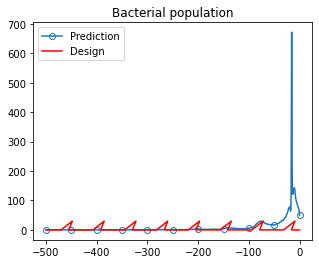

84 0.07942352816462517 loss =  239214.484375 loss_min =  222221.3125
85 0.07616013288497925 loss =  279908.03125 loss_min =  222221.3125
86 0.0746490340679884 loss =  273687.21875 loss_min =  222221.3125
87 0.06598678044974804 loss =  233918.234375 loss_min =  222221.3125
88 0.07500424981117249 loss =  246535.9375 loss_min =  222221.3125
89 0.06582927517592907 loss =  255141.65625 loss_min =  222221.3125
90 0.08057030662894249 loss =  335308.46875 loss_min =  222221.3125
91 0.06552490405738354 loss =  234441.65625 loss_min =  222221.3125
92 0.06547710113227367 loss =  253347.46875 loss_min =  222221.3125
93 0.0784199871122837 loss =  258948.71875 loss_min =  222221.3125
94 0.07554778829216957 loss =  245164.28125 loss_min =  222221.3125
95 0.07525932416319847 loss =  231862.984375 loss_min =  222221.3125
96 0.07821839675307274 loss =  279332.84375 loss_min =  222221.3125
97 0.07512393593788147 loss =  235778.578125 loss_min =  222221.3125
98 0.07803384028375149 loss =  343231.21875 los

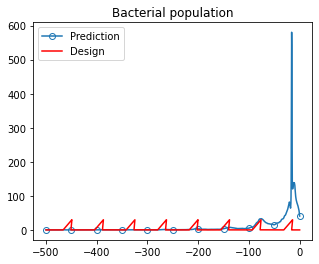

108 0.05459117144346237 loss =  251349.140625 loss_min =  221273.015625
109 0.06526242382824421 loss =  299494.65625 loss_min =  221273.015625
110 0.06458934396505356 loss =  268798.59375 loss_min =  221273.015625
111 0.06720362231135368 loss =  233392.203125 loss_min =  221273.015625
112 0.06427841633558273 loss =  304190.59375 loss_min =  221273.015625
113 0.06491671875119209 loss =  258263.5 loss_min =  221273.015625
114 0.07742568850517273 loss =  247551.890625 loss_min =  221273.015625
115 0.06433827057480812 loss =  277929.71875 loss_min =  221273.015625
116 0.07452992722392082 loss =  233754.0625 loss_min =  221273.015625
117 0.06666939333081245 loss =  247803.578125 loss_min =  221273.015625
118 0.053839005529880524 loss =  292419.78125 loss_min =  221273.015625
119 0.06449593976140022 loss =  252631.125 loss_min =  221273.015625
120 0.05470056273043156 loss =  228402.875 loss_min =  221273.015625
121 0.06627177074551582 loss =  326940.9375 loss_min =  221273.015625
122 0.06511

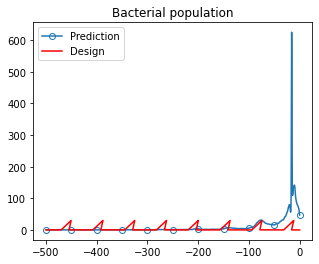

144 0.04370438680052757 loss =  346113.375 loss_min =  219948.390625
145 0.07541999779641628 loss =  255535.53125 loss_min =  219948.390625
146 0.06622487865388393 loss =  498756.9375 loss_min =  219948.390625
147 0.06909072399139404 loss =  296777.84375 loss_min =  219948.390625
148 0.06530264765024185 loss =  220454.5625 loss_min =  219948.390625
149 0.0669874045997858 loss =  267629.375 loss_min =  219948.390625
150 0.04666079580783844 loss =  238686.234375 loss_min =  219948.390625
151 0.060192884877324104 loss =  283831.34375 loss_min =  219948.390625
152 0.07778316922485828 loss =  263131.375 loss_min =  219948.390625
153 0.07713951542973518 loss =  251307.921875 loss_min =  219948.390625
154 0.06808427348732948 loss =  266453.53125 loss_min =  219948.390625
155 0.07716676406562328 loss =  585291.1875 loss_min =  219948.390625
156 0.07722686044871807 loss =  273319.125 loss_min =  219948.390625
157 0.07963209599256516 loss =  257532.71875 loss_min =  219948.390625
158 0.065427394

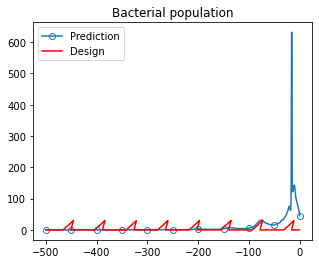

214 0.0774137806147337 loss =  275160.53125 loss_min =  219118.515625
215 0.07661146111786366 loss =  257210.578125 loss_min =  219118.515625
216 0.07625463977456093 loss =  518850.59375 loss_min =  219118.515625
217 0.08107839524745941 loss =  328572.6875 loss_min =  219118.515625
218 0.0687618013471365 loss =  229286.9375 loss_min =  219118.515625
219 0.06719371303915977 loss =  233350.296875 loss_min =  219118.515625
220 0.0702581275254488 loss =  330482.78125 loss_min =  219118.515625
221 0.06752978079020977 loss =  270474.75 loss_min =  219118.515625
222 0.05499891936779022 loss =  272721.03125 loss_min =  219118.515625
223 0.06565162912011147 loss =  237285.03125 loss_min =  219118.515625
224 0.06620108895003796 loss =  587645.1875 loss_min =  219118.515625
225 0.05463296175003052 loss =  292705.1875 loss_min =  219118.515625
226 0.05665595084428787 loss =  231227.125 loss_min =  219118.515625
227 0.05787363462150097 loss =  229960.078125 loss_min =  219118.515625
228 0.045143067

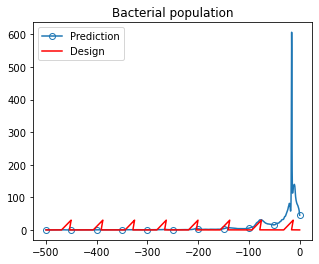

355 0.04391527734696865 loss =  246241.046875 loss_min =  218512.640625
356 0.046093324199318886 loss =  279968.28125 loss_min =  218512.640625
357 0.04392998106777668 loss =  232415.265625 loss_min =  218512.640625
358 0.044247277081012726 loss =  291257.0625 loss_min =  218512.640625
359 0.043516216799616814 loss =  286560.53125 loss_min =  218512.640625
360 0.044395023956894875 loss =  244579.25 loss_min =  218512.640625
361 0.04372131638228893 loss =  239603.640625 loss_min =  218512.640625
362 0.055765919387340546 loss =  372274.0625 loss_min =  218512.640625
363 0.04756132885813713 loss =  222006.390625 loss_min =  218512.640625
364 0.057285429909825325 loss =  288008.1875 loss_min =  218512.640625
365 0.05609642341732979 loss =  268484.125 loss_min =  218512.640625
366 0.054574478417634964 loss =  239480.484375 loss_min =  218512.640625
367 0.05738909728825092 loss =  229475.671875 loss_min =  218512.640625
368 0.06813373044133186 loss =  289444.375 loss_min =  218512.640625
369

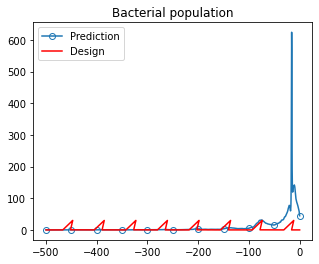

460 0.09728719666600227 loss =  220714.203125 loss_min =  218137.71875
461 0.09713278338313103 loss =  231649.640625 loss_min =  218137.71875
462 0.09661608748137951 loss =  235896.6875 loss_min =  218137.71875
463 0.09878919832408428 loss =  238678.6875 loss_min =  218137.71875
464 0.10077917762100697 loss =  328570.46875 loss_min =  218137.71875
465 0.1008166316896677 loss =  254122.484375 loss_min =  218137.71875
466 0.10096996836364269 loss =  365223.875 loss_min =  218137.71875
467 0.19545228965580463 loss =  328357.25 loss_min =  218137.71875
468 0.09888266772031784 loss =  297080.28125 loss_min =  218137.71875
469 0.10273205302655697 loss =  311307.1875 loss_min =  218137.71875
470 0.18481986224651337 loss =  261258.0625 loss_min =  218137.71875
471 0.10518122836947441 loss =  240503.140625 loss_min =  218137.71875
472 0.09705628082156181 loss =  376528.125 loss_min =  218137.71875
473 0.18448366597294807 loss =  243170.578125 loss_min =  218137.71875
474 0.1004544049501419 loss

In [14]:
################################################################
# inverse optimization for 1d
################################################################
torch.manual_seed(0)
np.random.seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

model = torch.load("catheter_plain_length_model_1d1000", map_location=device)
print(count_params(model))


epochs = 500

# constraints   
#               60 < L_p < 250
#               x1 = -0.5L_p 
#               
#               15 < x3 - x1 < L_p/2
#             -L_p < x2      < 0
#               20 < h       < 30
# def transfer(theta):
def transfer(theta):
    
    L_p = 60 + (250 - 60)/(1 + torch.exp(theta[0]))
    x1 = -0.5*L_p
    x3 = x1  + 15 + (L_p/2 - 15)/(1 + torch.exp(theta[2]))
    x2 = -L_p  + L_p/(1 + torch.exp(theta[1]))
    h = 20   + (10)/(1 + torch.exp(theta[3]))
    return L_p, x1, x2, x3, h


def inv_transfer(L_p, x2, x3, h):
    x1 = -0.5*L_p
    theta = np.zeros(4)
    theta[0] = np.log( (250 - 60)/(L_p - 60) - 1 )
    theta[1] = np.log( L_p/(x2 + L_p) - 1 )
    theta[2] = np.log( (L_p/2 - 15)/(x3 - x1  - 15) - 1 )
    theta[3] = np.log( 10/(h - 20 ) - 1 )
    return theta

# sample, uf, L_p, x1, x2, x3, h = inputPara[:, loss_min_ind]
# L_p, x2, x3, h = 80.0, -22.0, -22.0, 28.0
L_p, x2, x3, h = 100.0, -30.0, -30.0, 25.0
# L_p, x2, x3, h = 61.0, -30.0, -12.5, 29.0
# x2, x3, h = 73.85438537597656, -9.479606628417969, -19.35201644897461, 27.60188102722168
theta0 =    inv_transfer(L_p, x2, x3, h) 
print("initialize : ", theta0)

theta = torch.tensor(theta0.astype(np.float32) , requires_grad=True)
print("initialize : ", transfer(theta))


L_x = 500
N_s = 2001
xx_mask = (torch.linspace(1.0, 0, N_s) * (-L_x)).to(device)

max_iter = 100

optimizer = torch.optim.LBFGS([theta], max_iter=max_iter, lr=1.0, line_search_fn="strong_wolfe")

loss_min = torch.tensor(np.inf)
theta_min = torch.clone(theta)

for ep in range(epochs):
    t1 = default_timer()
    def loss_closure():
        
        L_p, x1, x2, x3, h = transfer(theta)
        
        x, XC, YC = catheter_mesh_1d_total_length(L_x, L_p, x2, x3, h, N_s)
    
        optimizer.zero_grad()
        out = torch.exp(model(x).squeeze())
        loss = -torch.sum(torch.matmul(out, xx_mask))* L_x/N_s
        loss.backward()
        
        return loss
    
    
    optimizer.step(loss_closure)

    t2 = default_timer()
 
    if ep%1==0:
        
        L_p, x1, x2, x3, h = transfer(theta)
        x, XC, YC = catheter_mesh_1d_total_length(L_x, L_p, x2, x3, h, N_s)
        out = torch.exp(model(x).squeeze())
        loss = -torch.sum(torch.matmul(out, xx_mask))* L_x/N_s
        print(ep, t2 - t1,  "loss = ", loss.item(), "loss_min = ", loss_min.item(),)
        
#         plt.savefig("Catheter."+str(ep).zfill(5)+".pdf")
        
        if loss < loss_min:
            
            theta_min = torch.clone(theta)
            loss_min = loss
            print(theta_min)
            mesh = x.detach().cpu().numpy()
            print("L_p, x1, x2, x3, h  = ", L_p.item(), x1.item(), x2.item(), x3.item(), h.item())


            plt.figure(figsize=(5,4))
            plt.title("Bacterial population")
            plt.plot(xx_mask.detach().cpu().numpy(), out.detach().cpu().numpy().T, "-o", fillstyle='none', markevery=len(xx_mask)//10, label="Prediction")
            plt.plot(mesh[0, :, 0], mesh[0, :, 1], color="r", label="Design")

            plt.legend()
            plt.show()
            
        theta = theta_min + torch.normal(mean=0.0, std=torch.ones(len(theta)))

In [76]:
torch.manual_seed(0)
np.random.seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

torch.normal(mean=0.0, std=torch.ones(len(theta)))

tensor([ 1.5410, -0.2934, -2.1788,  0.5684])

In [71]:
loss_min

tensor(203494.2188, device='cuda:0', grad_fn=<DivBackward0>)

In [21]:
################################################################
# inverse optimization for 1d
################################################################



L_x = 500
N_s = 2001
xx_mask = (torch.linspace(1.0, 0, N_s) * (-L_x)).to(device)
# learning_rate = 0.001
# epochs = 5001
# step_size = 500
# gamma = 0.5

# constraints   
#               60 < L_p < 250
#               x1 = -0.5L_p 
#               -L_p/4 < x2 - x3 < L_p/4
#               15 < x3 - x1 < L_p/4
#               20 < h < 30

loss_min = np.inf
L_p_min, x2_min, x3_min = np.NaN, np.NaN, np.NaN
mesh_min = np.NaN
density_min = np.NaN
nLp = 190
for L_p in np.linspace(60, 62, 20+1):
    print("L_p = ", L_p)
    x1 = -L_p/2
    for dx3_x1 in np.linspace(15, L_p/2, np.int64(np.round((L_p/2 - 15)))+1):
        print("dx3_x1 = ", dx3_x1)
        x3 = x1 + dx3_x1
        for h in np.linspace(29, 30, 11):
            for x2 in np.linspace(-L_p, 0, np.int64(np.round(L_p))+1):
            
                
                XC, YC = numpy_catheter_mesh_1d_total_length(L_x, L_p, x1, x2, x3, h, N_s)
                x = torch.tensor(np.vstack((XC,YC)).transpose()[np.newaxis, : ,:], dtype=torch.float).to(device) 
                
#                 L_p, x2, x3, h =  torch.tensor(L_p, dtype=torch.float), torch.tensor(x2, dtype=torch.float), torch.tensor(x3, dtype=torch.float), torch.tensor(h, dtype=torch.float)
#                 xx, XC, YC = catheter_mesh_1d_total_length(L_x, L_p, x2, x3, h, N_s)
#                 print(x - xx)
                out = model(x).squeeze()
                loss = -torch.sum(torch.matmul(out, xx_mask))* L_x/N_s
                if loss < loss_min:
                    L_p_min, x2_min, x3_min, h_min = L_p, x2, x3, h
                    mesh_min = np.copy(x.detach().cpu().numpy())
                    density_min = np.copy(out.detach().cpu().numpy())
                    loss_min = loss
                    print(L_p_min, x2_min, x3_min, h_min, loss_min)
                
plt.figure(figsize=(5,4))
plt.title("Bacterial population")
plt.plot(xx_mask.detach().cpu().numpy(), density_min, "-o", fillstyle='none', markevery=len(xx_mask)//10, label="Prediction")
plt.plot(mesh_min[0, :, 0], mesh_min[0, :, 1], color="r", label="Design")

plt.legend()
plt.show()



L_p =  60.0
dx3_x1 =  15.0
60.0 -60.0 -15.0 25.0 tensor(1163177.6250, device='cuda:0', grad_fn=<DivBackward0>)
60.0 -60.0 -15.0 26.0 tensor(1146735.1250, device='cuda:0', grad_fn=<DivBackward0>)
60.0 -60.0 -15.0 27.0 tensor(1127114.6250, device='cuda:0', grad_fn=<DivBackward0>)
60.0 -60.0 -15.0 28.0 tensor(1108573.5000, device='cuda:0', grad_fn=<DivBackward0>)
60.0 -60.0 -15.0 29.0 tensor(1086953.7500, device='cuda:0', grad_fn=<DivBackward0>)
60.0 -60.0 -15.0 30.0 tensor(1062519.3750, device='cuda:0', grad_fn=<DivBackward0>)
60.0 -59.0 -15.0 30.0 tensor(1058539.2500, device='cuda:0', grad_fn=<DivBackward0>)
60.0 -58.0 -15.0 30.0 tensor(1051428.2500, device='cuda:0', grad_fn=<DivBackward0>)
60.0 -57.0 -15.0 30.0 tensor(1041059.6250, device='cuda:0', grad_fn=<DivBackward0>)
60.0 -56.0 -15.0 30.0 tensor(1029130.6250, device='cuda:0', grad_fn=<DivBackward0>)
60.0 -55.0 -15.0 30.0 tensor(1016953.6875, device='cuda:0', grad_fn=<DivBackward0>)
60.0 -54.0 -15.0 30.0 tensor(1005137.5625, device

KeyboardInterrupt: 